# robotdatapy Intro Tutorial

Welcome to robotdatapy! At its core, robotdatapy is a package designed to make accessing and manipulating robot/geometric data easy in Python.

robotdatapy is built to support the following four main functionalities:
1. **Load data** from various sources. robotdatapy aims to be a single way to interface with a variety of different robot data sources including, ROS 1/2 bags, folders of images, KITTI data, csv files, custom text files, and more. Having a common interface no matter the data makes it easy to build up Python code that is independent of the robot dataset being used.
2. **Access different data sources at a specific time**. Time synchronization is important in robot applications and should be easy. robotdatapy makes it easy to do things like taking an image and finding the pose of the robot at the time the image was taken (interpolating poses if necessary).
3. **Manipulate data easily**. A common example of needing to manipulate data is needing to transform geometric quantities into different frames. robotdatapy makes transforming frames easy.
4. **Save modified data**. After manipulating data, you may want to save your results, like a timestamped set of images or a new trajectory estimate.

# Step 0: install robotdatapy

In [1]:
import os
import subprocess

# Source the ROS environment programmatically
ros_distro = "noetic" # TODO: Update with the name of your ROS distro
ros_setup_script = f"/opt/ros/{ros_distro}/setup.bash"  

command = f"bash -c 'source {ros_setup_script} && env'"
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
output, _ = proc.communicate()

# Parse and set environment variables
env_vars = {}
for line in output.decode().split("\n"):
    if "=" in line:
        key, value = line.split("=", 1)
        env_vars[key] = value

# Update the environment
os.environ.update(env_vars)

In [ ]:
!pip install robotdatapy
import robotdatapy as rdp
from robotdatapy.data import PoseData, ImgData, PointCloudData

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from typing import List

# Step 1: load the data

This tutorial uses the Kimera-Multi Dataset, available [here](https://github.com/MIT-SPARK/Kimera-Multi-Data).
Specifically, the outdoor dataset Thoth robot run is used.

First, download the Thoth ROS bag and ground truth trajectory CSV file. Set the following variables to point to the Thoth ROS bag path and the ground truth trajectory file.

(The Thoth bag is about 5 GB -- you could alternatively follow the same steps on your own ROS bag or robot data) 


In [ ]:
robot = "thoth"
bag_path = # TODO: put the path to the bag file here
gt_path = # TODO: put the path to the ground truth file here

Next, we will load the ground truth trajectory of the robot and the wheel odometry estimate.

In [4]:
gt_pose = PoseData.from_kmd_gt_csv(
    gt_path,
    interp=True,    # interpolates between poses if we request the pose at a time
                    # for which no pose has been recorded
    time_tol=10.0   # if we request a time and a pose is not found within time_tol
                    # seconds, an exception is raised
)

We can now easily plot the trajectory to get a sense of what data we are looking at.

<Axes: xlabel='x', ylabel='y'>

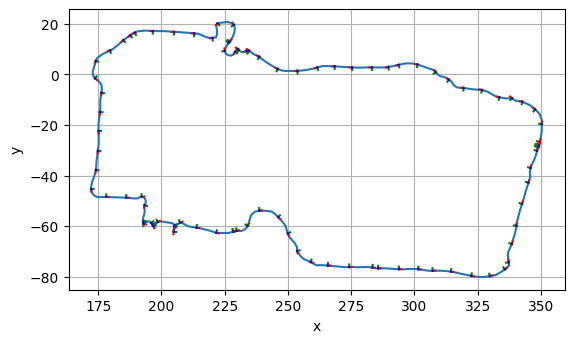

In [5]:
gt_pose.plot2d(dt=1.0, trajectory=True, pose=False)     # plots only position every second
gt_pose.plot2d(dt=5.0, trajectory=False, pose=True)     # plots coordinate frames of the poses every 5 seconds

Let's say we want to compare the raw wheel odometry (it won't look quite as nice!). 

ROS bags can be a little slow, so this may take a minute to load.

<Axes: xlabel='x', ylabel='y'>

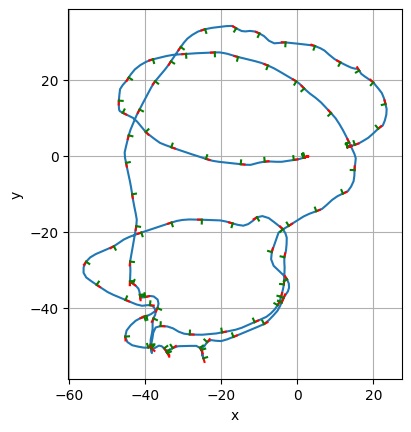

In [6]:
wheel_odom_pose = PoseData.from_bag(
    bag_path,
    topic=f"/{robot}/jackal_velocity_controller/odom",
    interp=True,
    time_tol=10.0
)

wheel_odom_pose.plot2d(dt=1.0, trajectory=True, pose=False)     # plots only position every second
wheel_odom_pose.plot2d(dt=5.0, trajectory=False, pose=True)     # plots coordinate frames of the poses every 5 seconds

Notice that the two trajectories start in different places. Maybe we want to compare the wheel odometry to the ground truth pose. We can register the two by using the `T_premultiply` property, which applies a transform before returning any pose.

In [7]:
# First, get the initial pose of both ground truth and wheel odometry
T_odom_body = wheel_odom_pose.pose(gt_pose.t0, multiply=False)
T_world_body = gt_pose.pose(gt_pose.t0, multiply=False)

# We will set T_premultiply so that it equals T^world_odom. 
# Then when we apply the transformation at each pose, the result will be:
# pose = T^world_odom * T^odom_body = T^world_bodyestimate
wheel_odom_pose.T_premultiply = T_world_body @ np.linalg.inv(T_odom_body)

Now we can plot the two pose sources starting in the same place. We can also just plot a part of the trajectory. In this case, we will just look at the first 120 second

<Axes: xlabel='x', ylabel='y'>

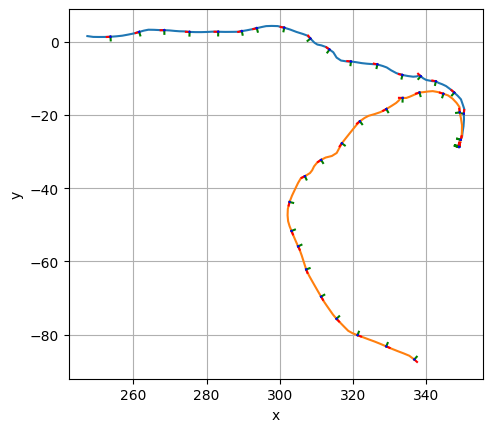

In [8]:
tf = gt_pose.t0 + 120
gt_pose.plot2d(dt=1.0, trajectory=True, pose=False, tf=tf)
gt_pose.plot2d(dt=5.0, trajectory=False, pose=True, tf=tf)
wheel_odom_pose.plot2d(dt=1.0, trajectory=True, pose=False, tf=tf)
wheel_odom_pose.plot2d(dt=5.0, trajectory=False, pose=True, tf=tf)

Next we will load and view the camera data and LiDAR point cloud data in a similar way (again, this may take a minute since we are loading a lot of data).

In [9]:
img_data = ImgData.from_bag(
    bag_path,
    topic=f"/{robot}/forward/color/image_raw/compressed", # camera iamge topic
    camera_info_topic=f"/{robot}/forward/color/camera_info", # camera info topic, not necessary but 
                                                             # gives us the camera intrinsics
    time_tol=0.1,
    compressed=True # tells the loader that the images are ROS CompressedImage messages
)

In [10]:
ptcld_data = PointCloudData.from_bag(
    bag_path,
    topic=f"/{robot}/lidar_points",
    time_tol=0.1
)

# Step 2: access different data sources at a specific time

As an example, let's say we want to write a function that takes in a specific time and draws the ground truth camera poses over the next five seconds on an image from the desired time.

First, we need to access an image at a desired time.

<Axes: >

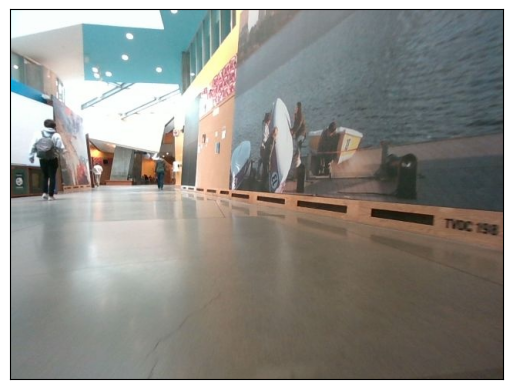

In [11]:
t = gt_pose.t0 + 80
img_data.show(t)

`robotdatapy` gets the image closest to the desired time. However, an image at that exact time-stamp might not exist. We can use the `time_tol` argument when we load the data to raise an error if we request an image at a time and there is no image that was taken near that time.

Let's see when exactly this image was taken.

In [12]:
print(f"Desired time: {t}")
print(f"Nearest time: {img_data.nearest_time(t)}")

Desired time: 1666028227.993841
Nearest time: 1666028228.0029619


We are going to want the pose at the same time as the image, so let's use the nearest image time as our desired time.

In [13]:
t_img = img_data.nearest_time(t)

Now, if we look for the nearest ground truth pose data time, we'll find there's some discrepancy. 

In [14]:
print(f"Desired time: {t_img}")
print(f"Nearest ground truth pose time: {gt_pose.nearest_time(t_img)}")
print(f"Difference: {t_img - gt_pose.nearest_time(t_img)}")

Desired time: 1666028228.0029619
Nearest ground truth pose time: 1666028227.9741693
Difference: 0.028792619705200195


In this case, it's only 30 ms, but even 30 ms can make a big difference sometimes. `robotdatapy` will naturally interpolate the poses so we can get the right pose at our desired time.

In [15]:
print(f"Nearest ground truth pose:\n{gt_pose.pose(gt_pose.nearest_time(t_img))}")
print(f"Interpolated pose at image time:\n{gt_pose.pose(t_img)}")
print(f"Position difference: {np.linalg.norm(gt_pose.position(gt_pose.nearest_time(t_img)) - gt_pose.position(t_img))}")

Nearest ground truth pose:
[[-9.79180954e-01 -2.00907969e-01 -2.89939253e-02  3.01262844e+02]
 [ 1.99897856e-01 -9.79214569e-01  3.43464029e-02  3.87729334e+00]
 [-3.52917401e-02  2.78355200e-02  9.98989328e-01  2.24585657e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Interpolated pose at image time:
[[-9.79223275e-01 -2.00711496e-01 -2.89253004e-02  3.01214522e+02]
 [ 1.99694847e-01 -9.79247566e-01  3.45857181e-02  3.89016629e+00]
 [-3.52667812e-02  2.80909067e-02  9.98983060e-01  2.24777160e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Position difference: 0.05004368390145081


In this case, the two poses were 5 cm apart. Again, maybe not hugely significant here, but if the robot was going faster or turning, interpolating to get the pose at the correct time makes a big difference.

Now, let's use the pose data and image data to draw the trajectories on the image. We will also need to project the poses from the 3D world onto the image, which we can use robotdatapy to do as well.

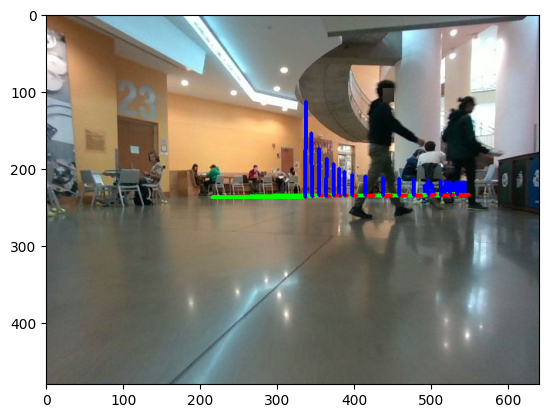

In [16]:
def world_points_to_pixels(points_world: np.ndarray, K: np.ndarray, T_world_body: np.ndarray):
    # Transform the world frame points into the robot frame
    points_robot = rdp.transform.transform(
        np.linalg.inv(T_world_body), points_world)

    # Then transform the robot frame points into the camera frame
    # (ground truth pose data uses xyz=forward,left,up frame convention,
    # we'll put it in camera coordinates using xyz=right,down,forward)
    points_cam = rdp.transform.transform(
        rdp.transform.T_RDFFLU, points_robot)

    # Project points to image, using robotdatapy's xyz_2_pixel method
    pixels = rdp.camera.xyz_2_pixel(points_cam, K)

    return pixels

def draw_pose_on_img(img_data: ImgData, pose_data: PoseData, t: float, 
                     trajectory_times: List[float]):
    img = img_data.img(t)
    for t_i in trajectory_times:
        img_t = img_data.nearest_time(t_i)

        # Get axes points in 3D (in the world frame)
        x_axis_w = np.array([
            pose_data.position(img_t),
            pose_data.position(img_t) + pose_data.pose(img_t)[:, 0][:3]
        ])
        y_axis_w = np.array([
            pose_data.position(img_t),
            pose_data.position(img_t) + pose_data.pose(img_t)[:, 1][:3]
        ])
        z_axis_w = np.array([
            pose_data.position(img_t),
            pose_data.position(img_t) + pose_data.pose(img_t)[:, 2][:3]
        ])

        # Project axes points to image
        x_axis_img = world_points_to_pixels(x_axis_w, img_data.K, 
                                            pose_data.pose(img_data.nearest_time(t)))
        y_axis_img = world_points_to_pixels(y_axis_w, img_data.K, 
                                            pose_data.pose(img_data.nearest_time(t)))
        z_axis_img = world_points_to_pixels(z_axis_w, img_data.K, 
                                            pose_data.pose(img_data.nearest_time(t)))

        # Draw axes on image
        img = cv.line(img, tuple(x_axis_img[0].astype(int)), 
            tuple(x_axis_img[1].astype(int)), (0, 0, 255), 3) # red for x-axis in BGR
        img = cv.line(img, tuple(y_axis_img[0].astype(int)),
            tuple(y_axis_img[1].astype(int)), (0, 255, 0), 3) # green for y-axis in BGR
        img = cv.line(img, tuple(z_axis_img[0].astype(int)),
            tuple(z_axis_img[1].astype(int)), (255, 0, 0), 3) # blue for z-axis in BGR

    return img

t = img_data.t0 + 110.0
trajectory_times = np.arange(t + 2.0, t + 50.0, 1.0)[::-1]
annotated_img = draw_pose_on_img(img_data, gt_pose, t, trajectory_times)
# convert from BGR to RGB
annotated_img = cv.cvtColor(annotated_img, cv.COLOR_BGR2RGB)
plt.imshow(annotated_img)

# Step 3: use the data

We've already done this a little bit in the last example when we drew the trajectory on the robot's image. Now we'll go through another example, this time of constructing and visualizing a large-scale point cloud using the point cloud data and pose data.

In [17]:
num_pointclouds = 100   # feel free to change this to 
                        # visualize a denser or sparse point cloud

# this will create the times we want to visualize the point clouds at
t = [ptcld_data.nearest_time(ti) for ti in 
     np.linspace(ptcld_data.t0, ptcld_data.tf, num_pointclouds)]

# now, apply the transformation from the pose data to the 
# point cloud data at each time
pc = np.vstack([rdp.transform.transform(gt_pose.pose(ti), 
            ptcld_data.pointcloud(ti).get_xyz()) for ti in t])

This last line aggregated all of the pointclouds into a single large point cloud across the run. We can now visualize it, along with the robot trajectory. 

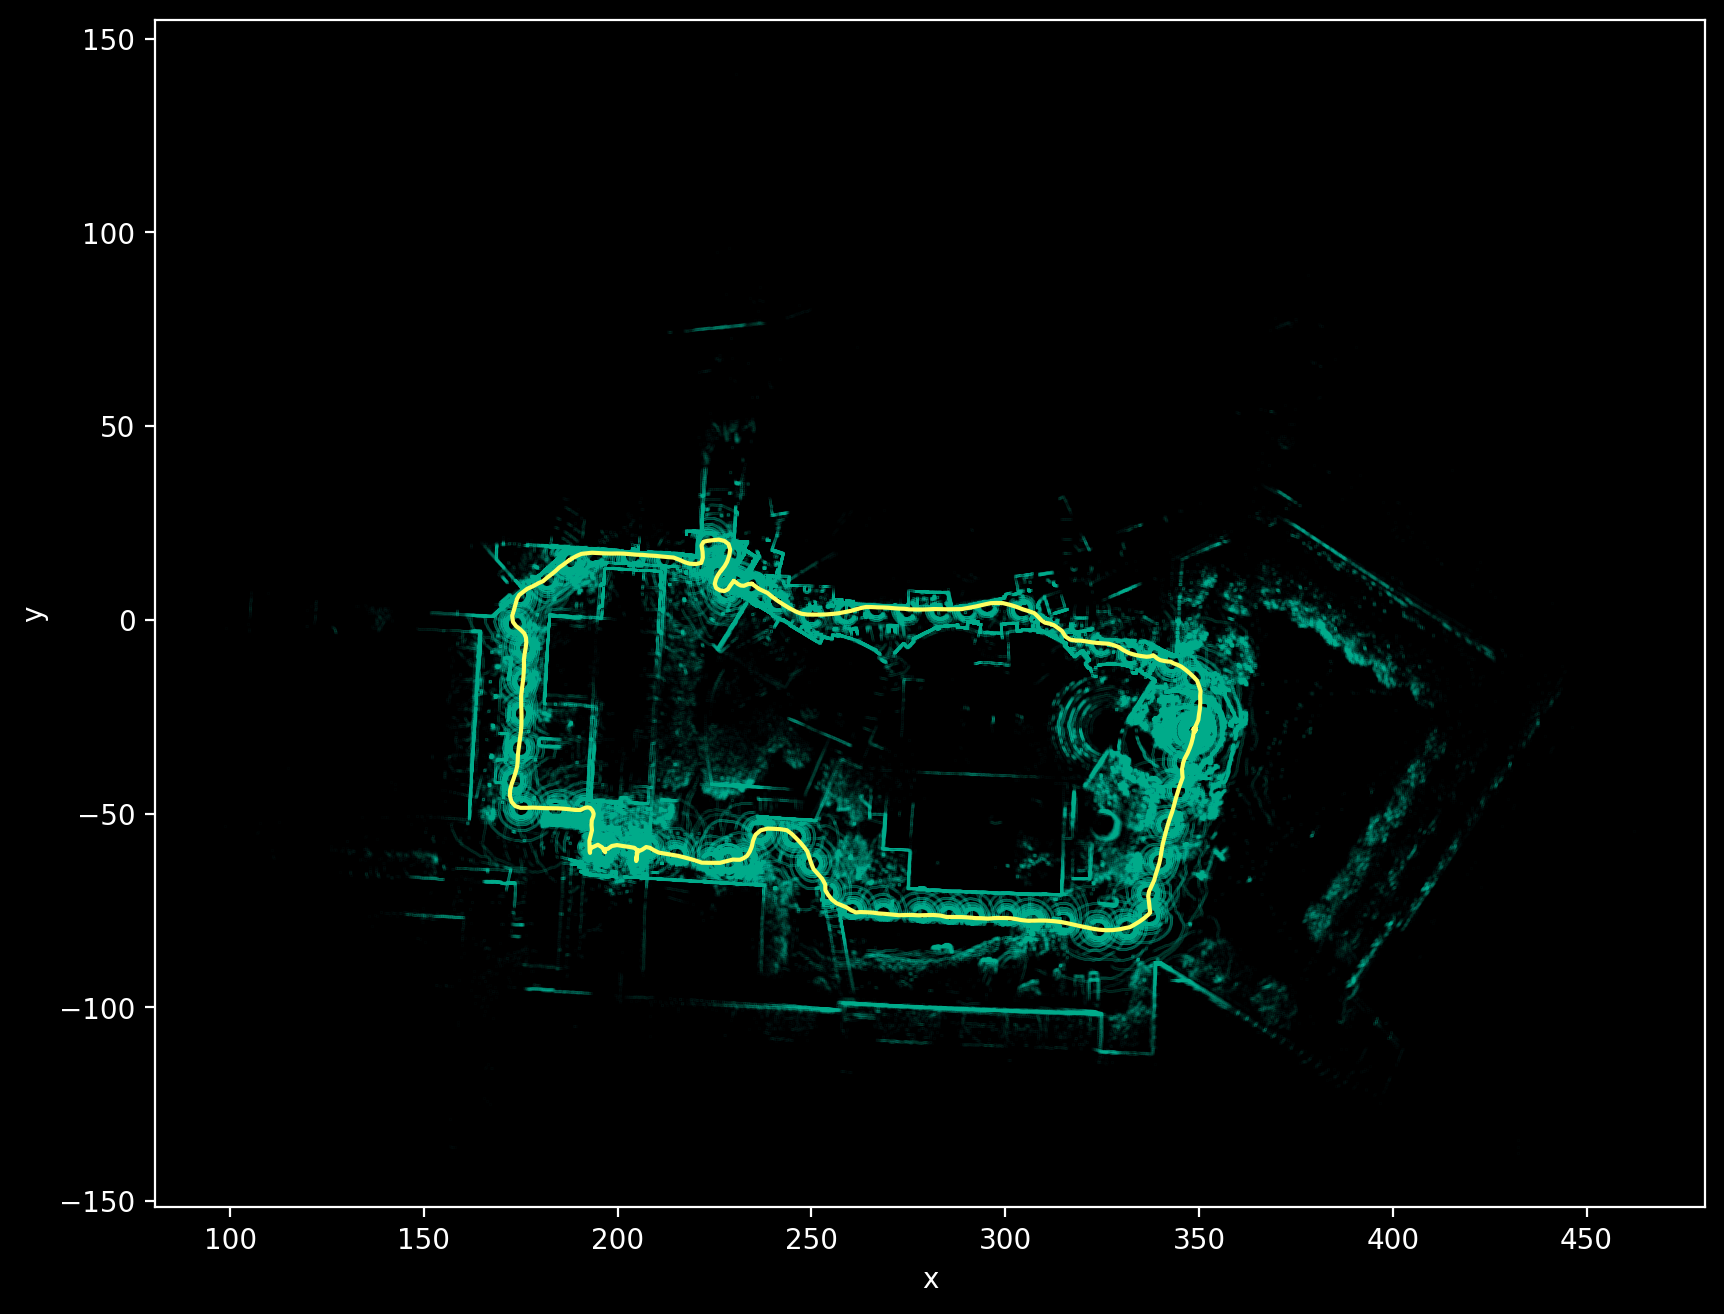

In [18]:
plt.style.use('dark_background')
dpi = 200
fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
ax.plot(pc[:,0], pc[:,1], '.', markersize=0.1, alpha=0.1, color='xkcd:aqua')
gt_pose.plot2d(dt=1.0, trajectory=True, pose=False, tf=gt_pose.tf, ax=ax, color='xkcd:canary')
ax.grid(False)


We can even do some cool things with the point cloud like view it from an angle and project it into a camera image to give it proper perspective.

It's worth noting that for most of these point cloud visualizations, `open3d` is a great and faster option for rendering, but plotting things yourself like we do here can sometimes give you more flexibility. 

In [19]:
def transform_and_project(T_world_cam, points):
    K = img_data.K # use the camera intrinsics from the image data

    # apply the transformation and project into the camera frame
    points_cam = rdp.transform.transform(np.linalg.inv(T_world_cam), points)
    points_cam = points_cam[points_cam[:,2] > 0.0]
    points_side_view = rdp.camera.xyz_2_pixel(points_cam, K)
    return points_side_view

# Series of rotations, feel free to change these around a bit:
# 1. Rotate the points by 180 degrees around the x-axis so the camera looks straight down
# 2. Rotate the points by -50 degrees around the z-axis so the camera is tilted
# 3. Rotate the points by 70 degrees around the x-axis so the camera is
#    looking at the scene when we translate it
T_world_cam = rdp.transform.xyz_rpy_to_transform([0., 0., 0.], [180., -0., 0.], degrees=True) @ \
    rdp.transform.xyz_rpy_to_transform([0., 0., 0.,], [0., 0., -50.], degrees=True) @ \
    rdp.transform.xyz_rpy_to_transform([0., 0., 0.,], [70., 0., 0.], degrees=True)

# set the position of the camera in the bottom left corner
T_world_cam[:3, 3] = np.array([400., -100., 40.])

# collect the points that define the trajecotry in the world frame
trajectory_poses = [gt_pose.pose(ti) for ti in np.arange(gt_pose.t0, gt_pose.tf, 1.0)]
trajectory_points = np.vstack([pose[:3,3] for pose in trajectory_poses])


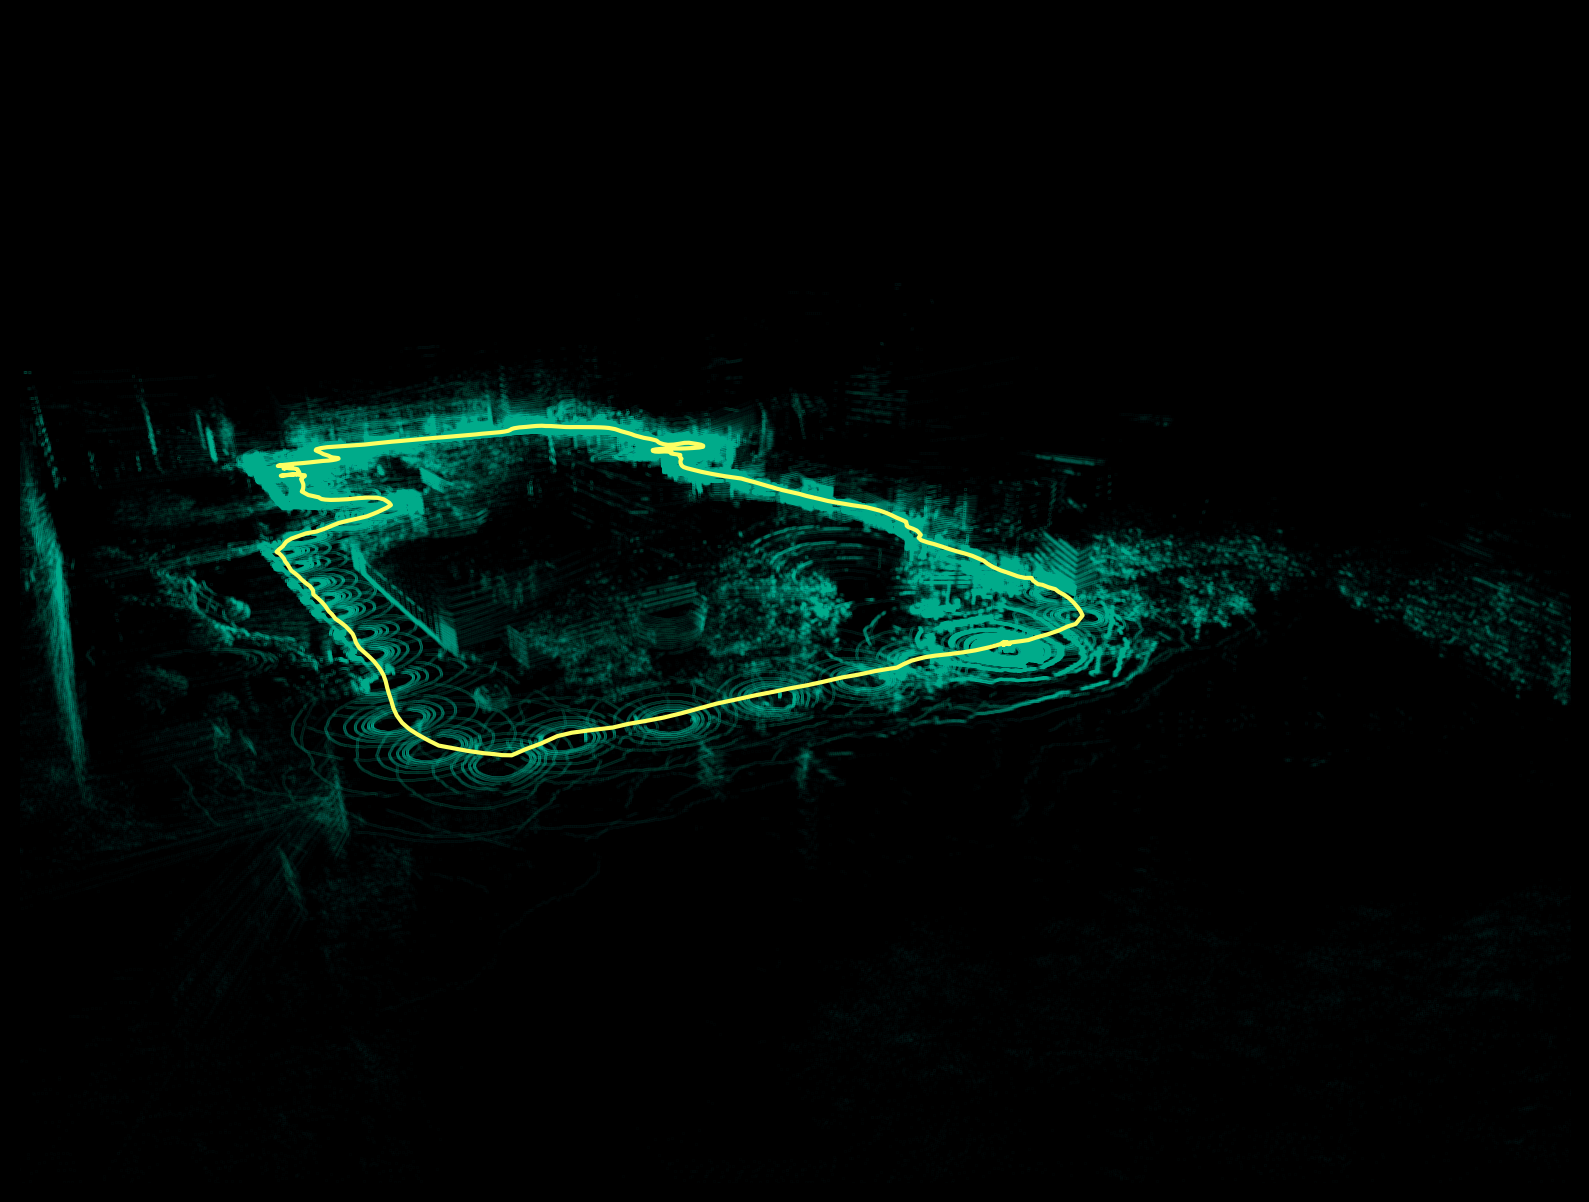

In [20]:
# Now, plot the point cloud and trajectory in the side view camera frame

def plot_pc_side_view(pc, trajectory_points, T_world_cam, ax=None):

    # project the pointcloud and trajectory points into a side view camera frame defined above
    pc_side_view = transform_and_project(T_world_cam, pc)
    trajectory_side_view = transform_and_project(T_world_cam, trajectory_points)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
    ax.plot(pc_side_view[:,0], -pc_side_view[:,1], '.', markersize=0.1, alpha=0.1, color='xkcd:aqua')
    ax.plot(trajectory_side_view[:,0], -trajectory_side_view[:,1], color='xkcd:canary')
    ax.set_aspect('equal')
    ax.set_xlim([0, img_data.width])
    ax.set_ylim([-img_data.height, 0])
    ax.axis('off')


plot_pc_side_view(pc, trajectory_points, T_world_cam)

# Step 4: save data

Lastly, let's make a cool visualization of spinning around the point cloud we created and use the `ImgData` class to save our visualization.

First, we will create a series of camera poses that look from the same angle we just saw above.

In [21]:
# An easy way to do this is to first rotate the point cloud and our camera frame so that
# the point cloud is centered at the origin. So, let's define a new frame T^world_pc

point_cloud_center = np.array([275., -40., 0.])
T_world_pc = rdp.transform.xyz_rpy_to_transform(point_cloud_center, [0., 0., 0.])

# The pose of the camera in this new frame is:
T_pc_cam = np.linalg.inv(T_world_pc) @ T_world_cam

# And let's express the points and trajectory in the point cloud centered frame as well
pc_centered = rdp.transform.transform(np.linalg.inv(T_world_pc), pc)
trajectory_points_centered = rdp.transform.transform(np.linalg.inv(T_world_pc), trajectory_points)

# Now we can rotate the pose of the camera T_pc_cam around the point cloud center z-axis
T_pc_cams = []
num_poses = 40   # increase this if you want a smoother video! (but will take longer to generate)
for theta in np.linspace(0, 360, num_poses):
    T_pc_cam_i = rdp.transform.xyz_rpy_to_transform(
        [0., 0., 0.], [0., 0., theta], degrees=True) @ T_pc_cam
    T_pc_cams.append(T_pc_cam_i)

In [ ]:
# We can choose a random one of these poses and visualize how we've rotated the camera
# around the point cloud

i = np.random.randint(num_poses)
plot_pc_side_view(pc_centered, trajectory_points_centered, T_pc_cams[i])

Now that we have our camera poses and the ability to view the point cloud from any of these poses, we'll iteratively view the point cloud and save the latest image. This is another step that might be a bit slow since using matplotlib to plot all of these points is a little slow.

In [23]:
# Create images from each camera pose
images = []
for i, T_pc_cam in enumerate(T_pc_cams):
    fig, ax = plt.subplots(figsize=(10,10), dpi=dpi)
    plot_pc_side_view(pc_centered, trajectory_points_centered, T_pc_cam, ax=ax)
    fig.canvas.draw()
    
    w, h = fig.canvas.get_width_height()
    image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image_rgb = image_flat.reshape(h, w, 3)
    image_bgr = cv.cvtColor(image_rgb, cv.COLOR_RGB2BGR)
    images.append(image_bgr)
    plt.close(fig)  # Close the figure to free memory

Now that we have our images, we can specify some timing, create an ImgData object, and save the ImgData object as a video.

In [24]:
fps = 10  # desired frames per second - increase to make the point cloud turn faster
times = np.arange(len(images)) / fps

viz_img_data = ImgData(times, images, data_type='raw')
viz_img_data.to_mp4("point_cloud_viz.mp4", fps=fps)

We also did some work to transform our wheel odometry to make it start in the same frame as our ground truth pose data. As another example, we can easily save that too.

In [25]:
wheel_odom_pose.to_csv("wheel_odom_pose.csv")

That finishes this tutorial for how to use`robotdatapy` to load data, access various data sources across different times, process the data, and finally save edited data. I hope you find it helpful in your work, and if there's a feature missing that you are interested in, I hope you consider making an issue or even better, making the change and creating a PR! 